
--- Manual Base ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


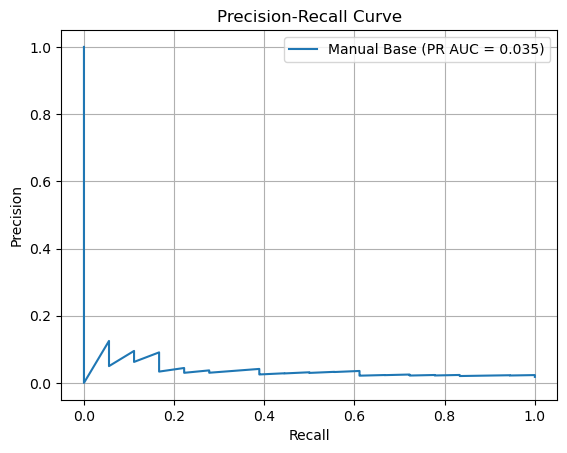

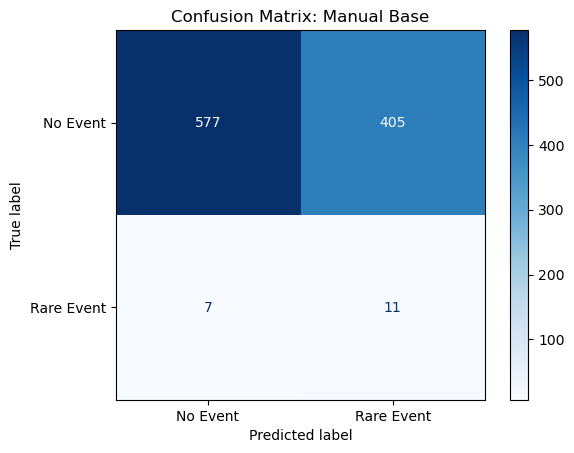


👾 Generation 1

--- Manual Upsampling_child ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.653
PR AUC: 0.035


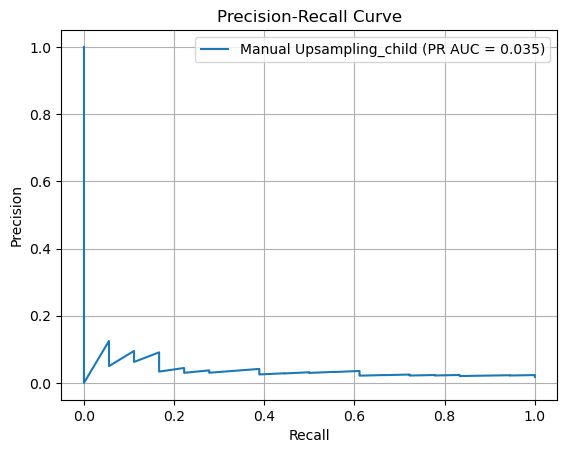

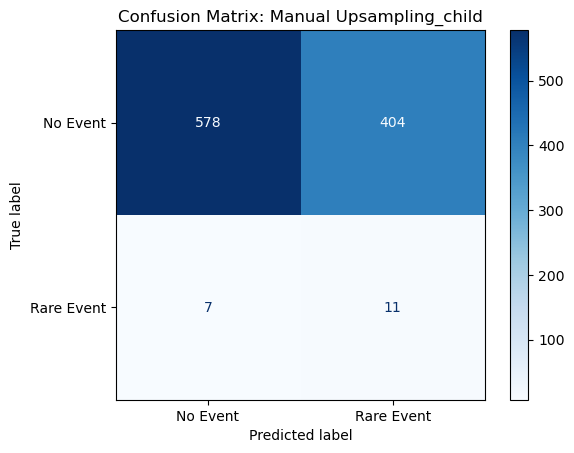


--- Manual Upsampling_child ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


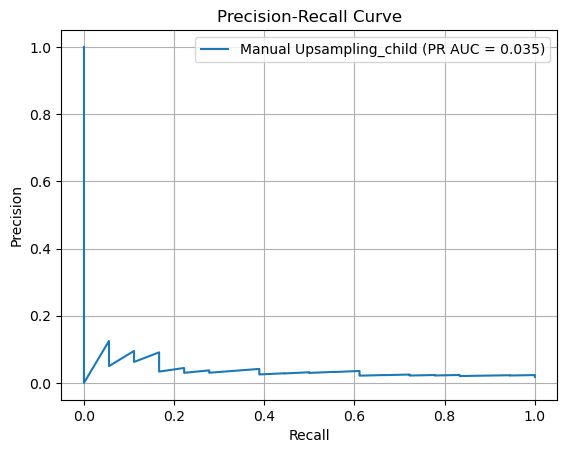

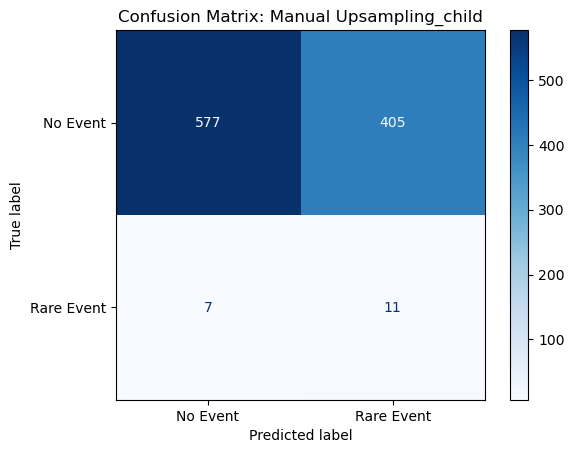

Model 1 - PR AUC: 0.0000, C=1.0000, l1_ratio=0.5000
Model 2 - PR AUC: 0.0000, C=1.0027, l1_ratio=0.5964
Model 3 - PR AUC: 0.0000, C=1.0836, l1_ratio=0.4824


In [108]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def mutate_params(base_params, noise=0.1):
    """Mutate hyperparameters with slight random noise."""
    return {
        "C": max(0.01, base_params["C"] + np.random.uniform(-noise, noise)),
        "l1_ratio": min(1.0, max(0.0, base_params["l1_ratio"] + np.random.uniform(-noise, noise)))
    }

def make_child_model(params):
    """Create a LogisticRegression model with given parameters."""
    return LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=params["l1_ratio"],
        C=params["C"],
        max_iter=2000,
        tol=1e-4,
        class_weight='balanced',
        random_state=42
    )

# 📦 Simplified breed-and-battle routine (run inline in your notebook)
population = []

# Use only manual upsampling for the test
resampled_datasets = {
    "Manual Upsampling": manual_upsampling(X_train, y_train, target_col)
}

# Initial model
base_params = {"C": 1.0, "l1_ratio": 0.5}
X_manual, y_manual = resampled_datasets["Manual Upsampling"]
model = make_child_model(base_params)
model.fit(X_manual, y_manual)

score = evaluate_model(model, X_test, y_test, results=[], label="Manual Base")

# ✅ Defensive fallback in case score is None or malformed
if not isinstance(score, dict) or "pr_auc" not in score or "roc_auc" not in score:
    score = {"roc_auc": 0, "pr_auc": 0}

population.append({
    "model": model,
    "params": base_params,
    "score": score,
    "label": "Manual Upsampling"
})

# 🧬 Begin evolution
generations = 1
top_k = 1

for gen in range(1, generations + 1):
    print(f"\n👾 Generation {gen}")

    # Filter out bad entries
    population = [p for p in population if isinstance(p["score"], dict) and "pr_auc" in p["score"]]
    population = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)[:top_k]

    new_population = []

    for parent in population:
        for _ in range(2):  # 2 children per top model
            child_params = mutate_params(parent["params"])
            child_model = make_child_model(child_params)
            X_res, y_res = resampled_datasets[parent["label"]]
            child_model.fit(X_res, y_res)

            score = evaluate_model(child_model, X_test, y_test, results=[], label=f"{parent['label']}_child")

            if not isinstance(score, dict) or "pr_auc" not in score or "roc_auc" not in score:
                score = {"roc_auc": 0, "pr_auc": 0}

            new_population.append({
                "model": child_model,
                "params": child_params,
                "score": score,
                "label": parent["label"]
            })

    population.extend(new_population)

# ✅ Sanity check
for i, model_info in enumerate(population):
    print(f"Model {i+1} - PR AUC: {model_info['score']['pr_auc']:.4f}, C={model_info['params']['C']:.4f}, l1_ratio={model_info['params']['l1_ratio']:.4f}")